### Chain Using LangGraph
In this section we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)



In [2]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Hello, Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding!",name="Sushant"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn PYTHON programming language",name="Sushant"))

for message in messages:
    message.pretty_print()



================================== Ai Message ==================================
Name: LLMModel

Hello, Please tell me how can I help
================================ Human Message =================================
Name: Sushant

I want to learn coding!
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Sushant

I want to learn PYTHON programming language


### Chat Models

We can use the sequence of message as input with the chatmodels using LLM's and OPENAI.

In [11]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-120b")
# llm=ChatGroq(model="llama-3-groq-tool-use-70b")
result=llm.invoke(messages)

In [12]:
result

AIMessage(content='Great choice! Python is one of the most beginner‑friendly languages and is used everywhere—from web development and data science to automation, game development, and AI. Below is a **step‑by‑step roadmap** you can follow, along with free resources, practice ideas, and tips to keep you motivated.\n\n---\n\n## 1️⃣ Get the Basics Right\n\n| Topic | What to Learn | Quick Resources |\n|-------|---------------|-----------------|\n| **Setting up** | Install Python (latest stable version) and a code editor (VS\u202fCode, PyCharm Community, or even Jupyter Notebook). | • Official installer: <https://python.org/downloads> <br>• VS\u202fCode: <https://code.visualstudio.com/> |\n| **Running code** | `python script.py` in terminal, interactive REPL (`python`), and notebooks (`jupyter`). | • Python REPL tutorial: <https://realpython.com/python-repl/> |\n| **Syntax & Data Types** | Variables, numbers, strings, booleans, lists, tuples, dictionaries, sets. | • Real Python “Python Bas

In [13]:
result.response_metadata 

{'token_usage': {'completion_tokens': 2491,
  'prompt_tokens': 117,
  'total_tokens': 2608,
  'completion_time': 5.402903283,
  'prompt_time': 0.004850497,
  'queue_time': 0.048004023,
  'total_time': 5.40775378,
  'completion_tokens_details': {'reasoning_tokens': 36}},
 'model_name': 'openai/gpt-oss-120b',
 'system_fingerprint': 'fp_70d048ba3c',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

In [14]:
def add(a:float,b:float)-> float:
    """ Add a and b
    Args:
        a (float): first float
        b (float): second float

    Returns:
        float
    """
    return a+b

In [15]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001DAA9FF3A00>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001DAFC45CAF0>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

#### Binding tool with llm

In [16]:
print("LLM TYPE", type(llm))

LLM TYPE <class 'langchain_groq.chat_models.ChatGroq'>


In [17]:
llm_with_tools=llm.bind_tools([add])

tool_call = llm_with_tools.invoke([
    HumanMessage(content="Calculate 234.56 + 789.12Calculate 234.56 + 789.12", name="Sushant")
])

In [18]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 234.56, 'b': 789.12},
  'id': 'fc_81430853-c68b-42a4-be75-ed04a798179c',
  'type': 'tool_call'}]

### Using messages as state

In [19]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
    
class State(TypedDict):
    message:list[AnyMessage] # inorder for not being overwritten and add in the contents 

#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [20]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

### Reducers with add_messages

In [21]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Sushant"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Sushant')]

In [22]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [23]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='a7c892c1-1a92-408c-a81a-00cc608f64ac'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Sushant', id='b2f84dc8-c887-4c29-8914-4a544d64d037'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='0ce01371-7eab-4b34-a8c9-2836fe840ba3')]

In [24]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

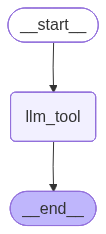

In [25]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
## invocation

messages=graph.invoke({"messages":"Calculate 234.56 + 789.12"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Calculate 234.56 + 789.12
================================== Ai Message ==================================
Tool Calls:
  add (fc_1224a522-2173-4194-98db-ef1bc8d2ecfe)
 Call ID: fc_1224a522-2173-4194-98db-ef1bc8d2ecfe
  Args:
    a: 234.56
    b: 789.12


In [27]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 234.56, 'b': 789.12},
  'id': 'fc_81430853-c68b-42a4-be75-ed04a798179c',
  'type': 'tool_call'}]

### add tool node

In [28]:
tools = [add]

In [29]:
from langchain_core.messages import SystemMessage

def llm_tool(state:State):
    system_msg = SystemMessage(
        content= "YOU MUST call a tool for any calculations. DONOT answer without calling the correct tool"
        
    )
    
    msgs = [system_msg] + state["messages"]
    return{"messages": [llm_with_tools.invoke(msgs)]}

In [30]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder=StateGraph(State)

## Add nodes

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)


graph_builder = builder.compile()



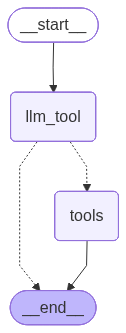

In [31]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [32]:
## invocation

messages=graph.invoke({"messages":"Calculate the precise sum of 15.75 and 32.89 "})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Calculate the precise sum of 15.75 and 32.89 
================================== Ai Message ==================================

The sum of 15.75 + 32.89 is **48.64**.


In [33]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 234.56, 'b': 789.12},
  'id': 'fc_81430853-c68b-42a4-be75-ed04a798179c',
  'type': 'tool_call'}]

In [34]:
# from langchain_core.tools import tool
# @tool
# def add(a: float, b: float) -> float:
#     """Add two numbers together. Use this for all addition operations."""
#     return a + b



In [35]:
# tools=[add]

# Bind the tools properly
# llm_with_tools = llm.bind_tools([add])

In [36]:
# from langchain_core.messages import SystemMessage

# # System message to force tool usage
# system_message = SystemMessage(content="You must use tools for all calculations and operations.")


# # Modify your llm_tool node to include the system message
# def llm_tool(state: State):
#     messages = state['messages']  + [system_message]
#     response = llm_with_tools.invoke(messages)
#     return {'messages': [response]}


In [37]:
# ## invocation

# messages=graph.invoke({"messages":"Calculate the precise sum of 15.75 and 32.89 "})

# for message in messages["messages"]:
#     message.pretty_print()

In [38]:
messages=graph.invoke({"messages":"What Machine Learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What Machine Learning
================================== Ai Message ==================================

**Machine Learning (ML)** is a branch of artificial intelligence (AI) that focuses on building systems that can learn from data, identify patterns, and make decisions or predictions with minimal human intervention. Instead of being explicitly programmed for every possible scenario, a machine‑learning model **learns** the underlying relationships from examples (training data) and then generalizes to new, unseen situations.

---

## Core Concepts

| Concept | What It Means |
|---------|---------------|
| **Data** | The raw material for learning (e.g., images, text, sensor readings). Quality and quantity of data are crucial. |
| **Model** | A mathematical representation (e.g., a neural network, decision tree) that maps inputs to outputs. |
| **Training** | The process of adjusting the model’s parameters to